# BAF642 금융시계열 과제 1

20249433 최재필

In [50]:
from pathlib import Path
import os, sys
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Time Series Decomposition & Stationarity tests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

## ARIMA, GARCH
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

## VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

## Kalman Filter
from scipy import stats, signal
from pykalman import KalmanFilter

## Performance analytics
import quantstats as qs

## Import Data

In [21]:
CWD_PATH = Path('.').resolve()
DATA_PATH = CWD_PATH / 'data'

In [44]:
def import_BB_data(filename, data_cols, return_col=None):
    data = pd.read_csv(DATA_PATH / filename, index_col=0, parse_dates=True)
    data.index.name = 'date'
    data.columns = data_cols
    
    vol_col = data_cols[4]
    ret_col = data_cols[5]

    try:
        data[vol_col] = data[vol_col].str.replace('K', '000')
        data[vol_col] = data[vol_col].str.replace('M', '000000')
        data[vol_col] = data[vol_col].str.replace('B', '000000000')
        data[vol_col] = data[vol_col].astype(float)
    except:
        pass

    data[ret_col] = data[ret_col].str.replace('%', '').astype(float) / 100

    data = data.astype(float)

    if return_col:
        data = data[return_col]
    
    return data

In [45]:
data_cols1 = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
data_cols2 = ['종가', '시가', '고가', '저가', '거래량', '변동 %']

In [48]:
v1x = import_BB_data('VIX.csv', data_cols2, '종가')
v1x.name = 'V1X'

v1x_futures = import_BB_data('VIX_futures.csv', data_cols2, '종가')
v1x_futures.name = 'V1X_futures'

v2x = import_BB_data('V2X.csv', data_cols1, 'Price')
v2x.name = 'V2X'

v2x_futures = import_BB_data('V2X_futures.csv', data_cols1, 'Price')
v2x_futures.name = 'V2X_futures'

## 1. 추세/계절성/잡음 분해
VIX와 V2X의 시계열을 추세, 계절성 및 잡음으로 분해하라.


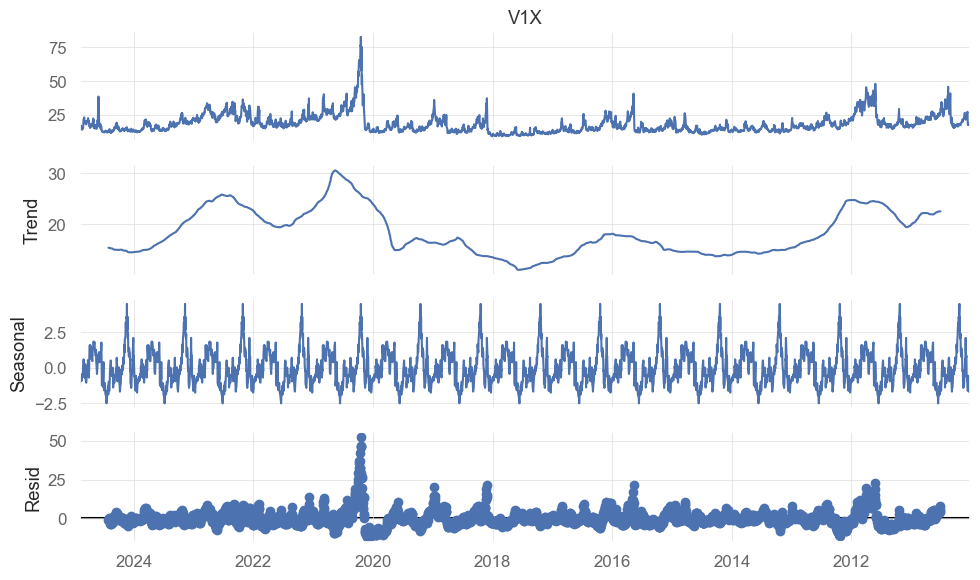

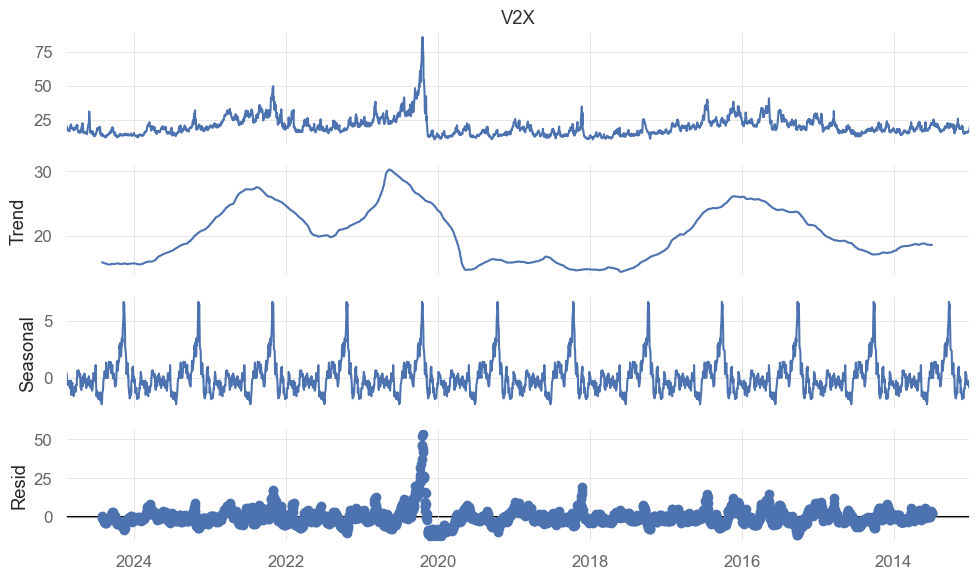

In [49]:
v1x_decompose = seasonal_decompose(v1x, model='additive', period=252).plot()
v2x_decompose = seasonal_decompose(v2x, model='additive', period=252).plot()


## 2. 단위근 테스트 및 정상성 확인
VIX와 V2X 각각에 대해 단위근 테스트를 실행하고 정상성을 살펴보라.


### Plot ACF, PACF

- ACF는 slow decaying을 보여주고 
- PACF는 빠른 decay를 보여줌 (short term memory)

결과: Stationary

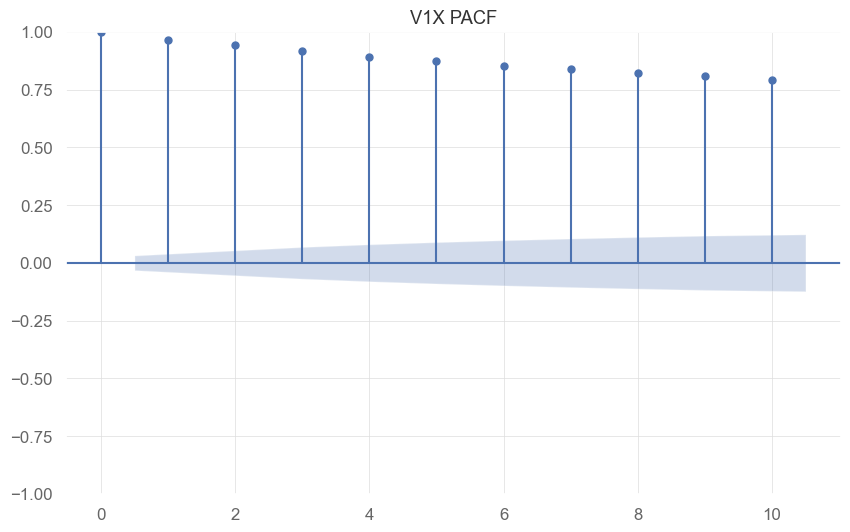

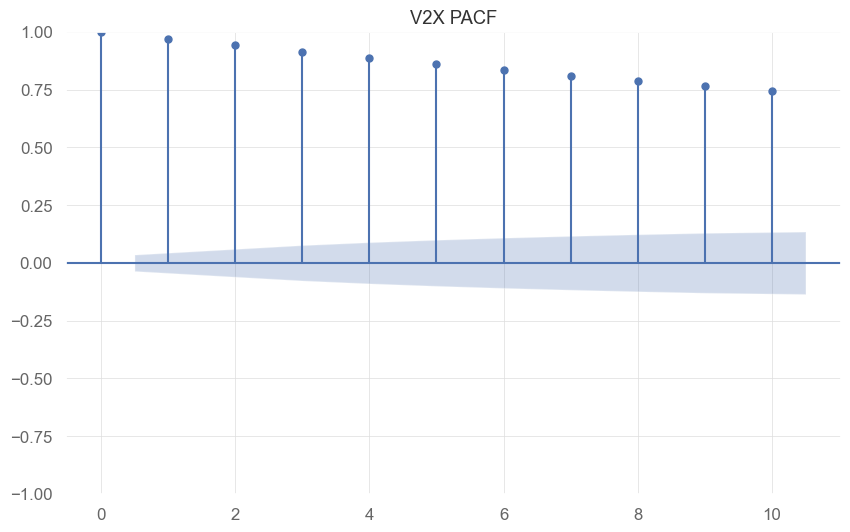

In [82]:
# ACF
plot_acf(v1x, lags=10, title='V1X PACF', )
plot_acf(v2x, lags=10, title='V2X PACF', )
plt.show()

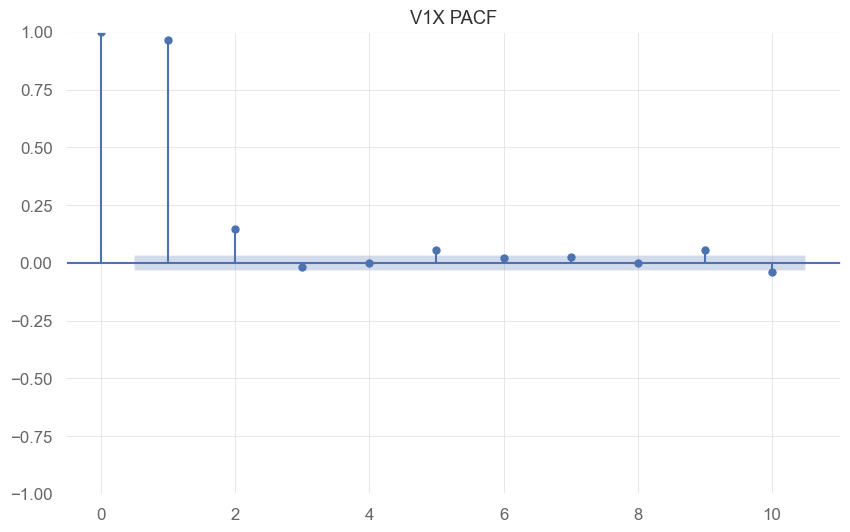

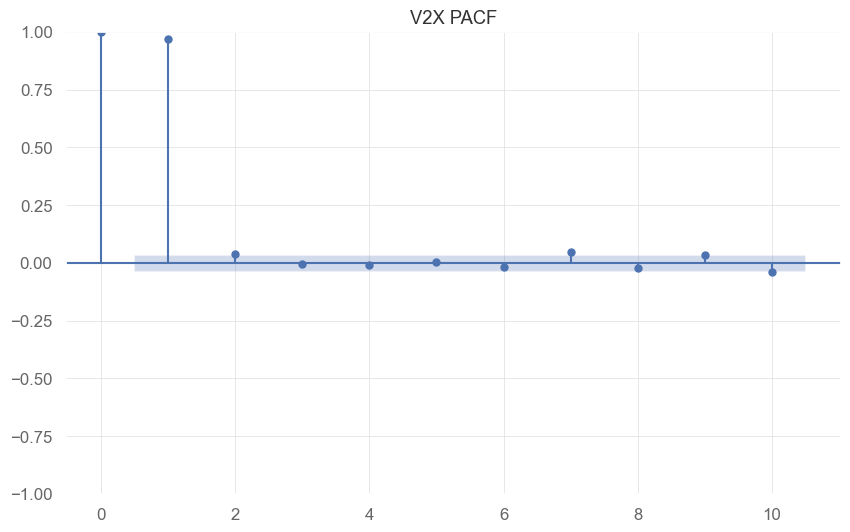

In [83]:
# PACF
plot_pacf(v1x, lags=10, title='V1X PACF', )
plot_pacf(v2x, lags=10, title='V2X PACF', )
plt.show()

### ADF Test

- H0: The series has a unit root (i.e, the series is not stationary)
    - If rejected --> Stationary. 
- Use `c` regression (and `ct`) regression because there's no clear trend. 
- Use AIC autolag rather than setting fixed `maxlags=`. 

결과: Stationary


In [77]:
def adf_result(data, regression='c', autolag='AIC', alpha=0.05):
    result = adfuller(data, regression=regression, autolag=autolag,)
    adf = result[0]
    print(f'ADF Statistic: {adf:.4f}')
    
    p_value = result[1]
    print(f'p-value: {p_value:.4f}')
    
    critical_values = result[4]
    for key, value in critical_values.items():
        print(f'Critical Value {key}: {value:.4f}')
    
    if p_value < alpha:
        print('Reject the null hypothesis: Stationary')
    else:
        print('Fail to reject the null hypothesis: Non-stationary')



In [78]:
adf_result(v1x)

ADF Statistic: -5.9974
p-value: 0.0000
Critical Value 1%: -3.4321
Critical Value 5%: -2.8623
Critical Value 10%: -2.5672
Reject the null hypothesis: Stationary


In [79]:
adf_result(v2x)

ADF Statistic: -5.6508
p-value: 0.0000
Critical Value 1%: -3.4325
Critical Value 5%: -2.8625
Critical Value 10%: -2.5673
Reject the null hypothesis: Stationary


What if `regression='ct'` (constant trend) ?

In [80]:
adf_result(v1x, regression='ct')

ADF Statistic: -6.0002
p-value: 0.0000
Critical Value 1%: -3.9612
Critical Value 5%: -3.4117
Critical Value 10%: -3.1277
Reject the null hypothesis: Stationary


In [81]:
adf_result(v2x, regression='ct')

ADF Statistic: -5.6511
p-value: 0.0000
Critical Value 1%: -3.9618
Critical Value 5%: -3.4119
Critical Value 10%: -3.1279
Reject the null hypothesis: Stationary


### KPSS Test

In [87]:
def kpss_result(data, regression='c', nlags='auto', alpha=0.05):
    # 'auto' (default): Uses a data-dependent method based on Hobijn et al. (1998)
    # 'legacy': Uses int(12 * (n / 100)**(1 / 4)) as in Schwert (1989)

    result = kpss(data, regression=regression, nlags=nlags)
    kpss_stat = result[0]
    print(f'KPSS Statistic: {kpss_stat:.4f}')
    
    p_value = result[1]
    print(f'p-value: {p_value:.4f}')
    
    critical_values = result[3]
    for key, value in critical_values.items():
        print(f'Critical Value {key}: {value:.4f}')
    
    if p_value < alpha:
        print('Fail to reject the null hypothesis: Stationary')
    else:
        print('Reject the null hypothesis: Non-stationary')

# 반대로 Fail to reject 해야 stationary라는 점에 주의

In [88]:
kpss_result(v1x)

KPSS Statistic: 0.5631
p-value: 0.0275
Critical Value 10%: 0.3470
Critical Value 5%: 0.4630
Critical Value 2.5%: 0.5740
Critical Value 1%: 0.7390
Fail to reject the null hypothesis: Stationary


In [ ]:
kpss_result(v2x) # V2X의 경우 여기선 non-stationary라고 나옴 

KPSS Statistic: 0.2879
p-value: 0.1000
Critical Value 10%: 0.3470
Critical Value 5%: 0.4630
Critical Value 2.5%: 0.5740
Critical Value 1%: 0.7390
Reject the null hypothesis: Non-stationary


C:\Users\chlje\AppData\Local\Temp\ipykernel_47968\2646918596.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data, regression=regression, nlags=nlags)



## 3. ARIMA GARCH 모델 적용
VIX와 V2X 각각에 대해 ARIMA GARCH 모델을 적용하라.



## 4. Multivariate GARCH 모델 적용
VIX와 V2X에 대해 Multivariate GARCH 모델을 적용해보라.



## 5. VAR 모델 및 분산 분석
VIX와 V2X를 이용해 VAR 모델을 만들고, Granger causality 테스트를 실행하고, Impulse response 그래프와 분산 분해(Variance Decomposition)를 계산하고 그래프로 보여라.



## 6. VECM 모델 구축
VIX와 V2X를 이용해 공적분관계를 확인하고, VECM 모델을 구축하라.



## 7. 페어 트레이딩
트레이딩 경계(평균 +/- some 표준편차)를 설정하고 다음 방법으로 페어 트레이딩을 수행하라.



### 1) 단순 스프레드를 이용한 페어 트레이딩



### 2) 공적분관계를 이용한 페어 트레이딩



### 3) 칼만 필터를 이용한 페어 트레이딩



## 8. 최소 총 이익(MTP) 경계 및 백테스트
최소 총 이익(MTP) 경계를 구하고 이를 이용한 백테스트 결과를 제시하라. (논문과 블로그 참조)
